# DR CI for Comparing Abstaining Classifiers under MAR

Experiment 1.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from collections import OrderedDict

from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed
import time
import itertools as it

import comparecast as cc
import comparecast_causal as c3

[MLENS] backend: threading


In [2]:
RANDOM_SEED = 1234

rng = np.random.default_rng(RANDOM_SEED)

Configurations for evaluation:

In [3]:
ALPHA = 0.05
SCORING_RULE = "zero_one"
EPSILON = 0.2
CLIP_PI = EPSILON  # how much to clip large values of estimated abstention probability
N_TRIALS = 1000     # repetitions  
N_JOBS = -1         # number of CPU cores for parallel processing
MIXED_EST = False   # use mixed estimation

In [4]:
PLOTS_DIR = "./plots/binary_mar/experiment1{}/{}/eps{:g}".format(
    "_mixed" if MIXED_EST else "", SCORING_RULE, EPSILON,
)
os.makedirs(PLOTS_DIR, exist_ok=True)

FONT = "Liberation Serif"  # for servers & colab; if not use "DejaVu Serif"
cc.set_theme(style="whitegrid", font=FONT)

## Data

Generate synthetic predictions and abstentions.

In [5]:
n = 2000
epsilon = EPSILON        # positivity level
threshold = 0.2          # how close to border do you switch to abstention?
noise_level = 0.15       # noise level of the true decision boundary
threshold_b_mult = 1.25  # width of the "cautiousness" region for B, relative to A's

data = c3.data_utils.abstaining_classifiers.generate_binary_mar(
    n=n, 
    epsilon=epsilon,
    threshold=threshold,
    noise_level=noise_level,
    is_comparison=True,
    threshold_b_mult=threshold_b_mult,
    rng=rng,
    for_plotting=True,
)
data

,$X_0$,$X_1$,$Y$,Classifier,$P$,$\hat{Y}$,Abstain,Correct
0,0.976700,0.380196,1,A,0.588289,1,No,Yes
1,0.923246,0.261692,1,A,0.546103,1,No,Yes
2,0.319097,0.118091,0,A,0.362897,0,No,Yes
3,0.241766,0.318534,0,A,0.391813,0,Yes,Yes
4,0.964079,0.263650,1,A,0.556687,1,Yes,Yes
...,...,...,...,...,...,...,...,...
3995,0.447085,0.572443,1,B,0.363788,0,No,No
3996,0.785321,0.039024,0,B,0.409126,0,Yes,Yes
3997,0.484321,0.654514,1,B,0.431478,0,Yes,No
3998,0.219913,0.875807,1,B,0.507700,1,Yes,Yes


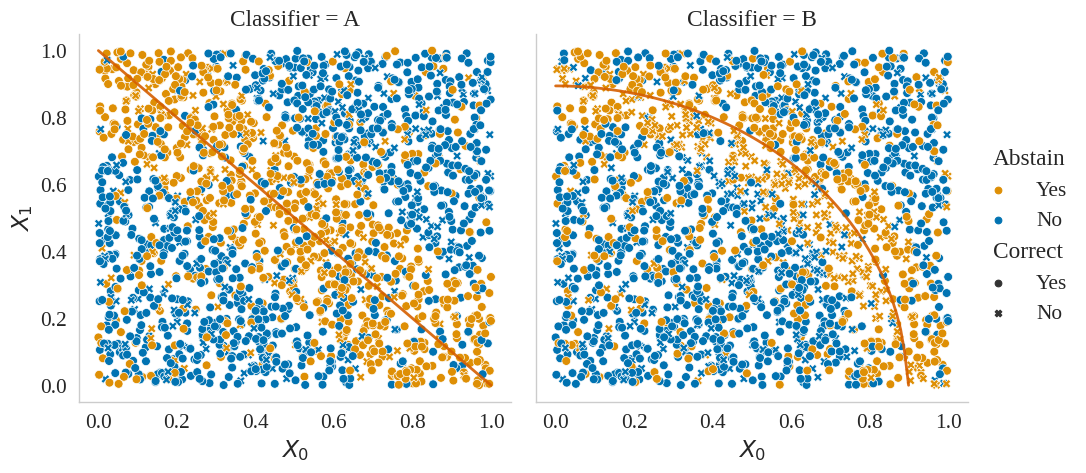

In [6]:
fg = sns.relplot(
    x=r"$X_0$",
    y=r"$X_1$",
    style="Correct",
    col="Classifier",
    hue="Abstain",
    style_order=["Yes", "No"],
    hue_order=["Yes", "No"],
    palette=[cc.get_color_by_index(1), cc.get_color_by_index(0)],
    data=data,
    s=40,
)
for ax in fg.axes[0]:
    ax.grid()

x0 = np.linspace(0, 1, 100)
# A boundary
x1_a = 1 - x0
fg.axes[0, 0].plot(x0, x1_a, linewidth=2, alpha=0.9, color=cc.get_color_by_index(3))

# B boundary
x1_b = np.sqrt(np.maximum(0, 0.8 - x0 ** 2))
fg.axes[0, 1].plot(x0[x0 <= np.sqrt(0.81)], x1_b[x0 <= np.sqrt(0.81)], 
                   linewidth=2, alpha=0.9, color=cc.get_color_by_index(3))

fg.savefig(os.path.join(PLOTS_DIR, "classifiers.pdf"))
None

## `DREvalAbst` for comparison

In [7]:
def convert_pd_to_np(data, for_plotting=False):
    idx_a = data["Classifier"] == "A"
    idx_b = data["Classifier"] == "B"
    # numpy
    if for_plotting:
        X = data.loc[idx_a, [col for col in data if col.startswith(r"$X")]].to_numpy()
        y = data.loc[idx_a, r"$Y$"].to_numpy()
        predictions = data.loc[idx_a, r"$P$"].to_numpy()
        abstentions = data.loc[idx_a, "Abstain"].to_numpy() == "Yes"
        predictions_b = data.loc[idx_b, r"$P$"].to_numpy()
        abstentions_b = data.loc[idx_b, "Abstain"].to_numpy() == "Yes"
    else:
        X = data.loc[idx_a, [col for col in data if col.startswith("X")]].to_numpy()
        y = data.loc[idx_a, "Y"].to_numpy()
        predictions = data.loc[idx_a, "prediction"].to_numpy()
        abstentions = data.loc[idx_a, "abstention"].to_numpy()
        predictions_b = data.loc[idx_b, "prediction"].to_numpy()
        abstentions_b = data.loc[idx_b, "abstention"].to_numpy()
    
    return X, y, predictions, abstentions, predictions_b, abstentions_b

In [8]:
X, y, predictions, abstentions, predictions_b, abstentions_b = convert_pd_to_np(data, for_plotting=True)

# compute scores
scores_a = c3.compute_scores(predictions, abstentions, y, SCORING_RULE)
scores_b = c3.compute_scores(predictions_b, abstentions_b, y, SCORING_RULE)
print("oracle CF score difference: {:.3f}".format(scores_a["oracle_cf_score"] - scores_b["oracle_cf_score"]))
print("-" * 40)
for name, scores in [["A", scores_a], ["B", scores_b]]:
    print(f"[Classifier {name}]")
    print("selective score: {:.3f}".format(scores["selective_score"]))
    print("coverage: {:.3f}".format(scores["coverage"]))
    print("(oracle) counterfactual score: {:.3f}".format(scores["oracle_cf_score"]))

oracle CF score difference: 0.116
----------------------------------------
[Classifier A]
selective score: 0.856
coverage: 0.543
(oracle) counterfactual score: 0.860
[Classifier B]
selective score: 0.805
coverage: 0.598
(oracle) counterfactual score: 0.744


In [9]:
def run_experiment(X, y, predictions, abstentions, predictions_b, abstentions_b,
                   estimator, learner, alpha, scoring_rule, clip_pi, rng, verbose=False):
    """Compute DR CI and calculate diagnostics."""

    # compute scores
    scores_a = c3.compute_scores(predictions, abstentions, y, scoring_rule)
    scores_b = c3.compute_scores(predictions_b, abstentions_b, y, scoring_rule)

    if verbose:
        print("{:g}% DR CI for CF score difference [estimator: {:s}, learner: {:s}]".format(
            100 * (1 - ALPHA), estimator, learner,
        ))

    # compute CI
    drci_obj = c3.DREvalAbst(
        inputs=X, 
        labels=y, 
        predictions=np.array([1 - predictions, predictions]).T,
        abstentions=abstentions,
        predictions_b=np.array([1 - predictions_b, predictions_b]).T,
        abstentions_b=abstentions_b,
        scoring_rule=SCORING_RULE,
        pi_fn=c3.get_learner("c", learner),
        mu0_fn=c3.get_learner("r", learner),
        clip_pi=clip_pi,
        estimator=estimator,
        mixed_estimation=MIXED_EST,
        mixed_coef=None,  # find optimal one
        cross_fit=True,
        alpha=ALPHA,
        rng=rng,
        verbose=verbose,
    )
    ci = drci_obj.compute_ci()
    oracle_cf_diff = scores_a["oracle_cf_score"] - scores_b["oracle_cf_score"]
    if verbose:
        print("Cross-fit estimate: {:.5f}".format(drci_obj.estimate.mean()))
        print("Asymptotic CI: ({:.5f}, {:.5f})".format(ci[0], ci[1]))
        print("CI width: {:.5f}".format(ci[1] - ci[0]))
        print("Contains oracle CF score:", ci[0] <= oracle_cf_diff <= ci[1])
        print("-" * 40)

    # returns a summary dict
    summary = dict(
        alpha=alpha,
        scoring_rule=scoring_rule,
        estimator=estimator,
        learner=learner,
        oracle_cf_diff=oracle_cf_diff,
        estimate=(ci[0] + ci[1]) / 2,
        ci=ci,
        width=ci[1] - ci[0],
        miscovered=(oracle_cf_diff < ci[0]) or (ci[1] < oracle_cf_diff),
    )
    return summary

Single runs:

In [10]:
estimators = ["Plugin", "IPW", "DR"]
learners = ["Linear", "RandomForest", "SuperLearner"]
for estimator in estimators:
    for learner in learners:
        summary = run_experiment(
            X, y, predictions, abstentions, predictions_b, abstentions_b,
            estimator=estimator, learner=learner, 
            alpha=ALPHA, scoring_rule=SCORING_RULE, clip_pi=CLIP_PI, rng=rng,
            verbose=True,
        )

95% DR CI for CF score difference [estimator: Plugin, learner: Linear]
mu0 [split=MSE] evaluation: 0 0.13027
mu0_b [split=MSE] evaluation: 0 0.14963
mu0 [split=MSE] evaluation: 1 0.11760
mu0_b [split=MSE] evaluation: 1 0.16685
Cross-fit estimate: 0.05128
Asymptotic CI: (0.04987, 0.05269)
CI width: 0.00282
Contains oracle CF score: False
----------------------------------------
95% DR CI for CF score difference [estimator: Plugin, learner: RandomForest]
mu0 [split=MSE] evaluation: 0 0.15864
mu0_b [split=MSE] evaluation: 0 0.16501
mu0 [split=MSE] evaluation: 1 0.13958
mu0_b [split=MSE] evaluation: 1 0.15187
Cross-fit estimate: 0.10370
Asymptotic CI: (0.09235, 0.11505)
CI width: 0.02270
Contains oracle CF score: False
----------------------------------------
95% DR CI for CF score difference [estimator: Plugin, learner: SuperLearner]
mu0 [split=MSE] evaluation: 0 0.11823
mu0_b [split=MSE] evaluation: 0 0.14223
mu0 [split=MSE] evaluation: 1 0.12880
mu0_b [split=MSE] evaluation: 1 0.14992
C

In [11]:
summary

{'alpha': 0.05,
 'scoring_rule': 'zero_one',
 'estimator': 'DR',
 'learner': 'SuperLearner',
 'oracle_cf_diff': 0.11649999999999994,
 'estimate': 0.10639919415963661,
 'ci': array([0.07611513, 0.13668326]),
 'width': 0.06056812481419005,
 'miscovered': False}

## Miscoverage Rates

Averaged over `n_trials`.

* Estimator choices: `Plugin`, `IPW`, `DR`
* Nuisance function learners: `Linear`, `RandomForest`, `SuperLearner`

In [12]:
# a parallelizable stochastic function (can vary epsilon, estimator, learner)
def compute_miscov(seed):
    rng = np.random.default_rng(seed)
    data = c3.data_utils.abstaining_classifiers.generate_binary_mar(
        n=n, 
        epsilon=epsilon,
        threshold=threshold,
        noise_level=noise_level,
        is_comparison=True,
        threshold_b_mult=threshold_b_mult,
        rng=rng,
        return_np_arrays=True,
    )
    summary = run_experiment(
        *data, 
        estimator=estimator, learner=learner, 
        alpha=ALPHA, scoring_rule=SCORING_RULE, clip_pi=CLIP_PI, rng=rng,
        verbose=False,
    )
    return summary["miscovered"], summary["width"]

In [ ]:
# parallel RNG (independent seeds; some randomness from individual learner training steps)
use_parallel = True
rng = np.random.default_rng(RANDOM_SEED)
ss = rng.bit_generator._seed_seq
child_states = ss.spawn(N_TRIALS)

miscov_summary = OrderedDict()
miscov_df_rows = []
for estimator in estimators:
    for learner in learners:
        t0 = time.time()
        if use_parallel:
            results = Parallel(n_jobs=N_JOBS)(
                    delayed(compute_miscov)(seed) for seed in child_states
            )
        else:
            results = [compute_miscov(seed) for seed in range(N_TRIALS)]
        miscov_df_rows.extend([{"Estimator": estimator, "Learner": learner, 
                                "Miscoverage": mc, "Width": min(2, w)}  # assumed: bounded score
                               for mc, w in results])
        miscovs, widths = zip(*results)
        m = np.mean(miscovs)
        se = np.sqrt(m * (1-m) / len(miscovs))
        print("miscoverage rate [estimator: {}, learner: {}, n: {}]: {} +/- {:.3f}".format(
            estimator, learner, N_TRIALS, m, se
        ))
        miscov_summary[estimator, learner] = m, se, np.mean(widths), np.std(widths)

        t1 = time.time()
        print("elapsed time (n_jobs={}): {:.2f}s".format(N_JOBS, t1 - t0))

In [14]:
miscov_df = pd.DataFrame(miscov_df_rows)
miscov_df.to_csv(os.path.join(PLOTS_DIR, "miscoverage.csv"))

# latex
print("Learner      &\t" + "\t\t & ".join(estimators))
for learner in learners:
    print(" & ".join(["{:12s}".format(learner)] + 
                       ["{:.2f} +/- {:.4f} (width: {:.2f} +/- {:.4f})".format(*miscov_summary[estimator, learner])
                        for estimator in estimators]))

Learner      &	Plugin		 & IPW		 & DR
Linear       & 1.00 +/- 0.0000 (width: 0.00 +/- 0.0007) & 0.76 +/- 0.0136 (width: 0.09 +/- 0.0022) & 0.99 +/- 0.0022 (width: 0.04 +/- 0.0014)
RandomForest & 0.64 +/- 0.0152 (width: 0.02 +/- 0.0013) & 0.14 +/- 0.0109 (width: 0.13 +/- 0.0035) & 0.05 +/- 0.0071 (width: 0.07 +/- 0.0031)
SuperLearner & 0.91 +/- 0.0092 (width: 0.01 +/- 0.0025) & 0.03 +/- 0.0057 (width: 0.12 +/- 0.0032) & 0.05 +/- 0.0067 (width: 0.06 +/- 0.0029)


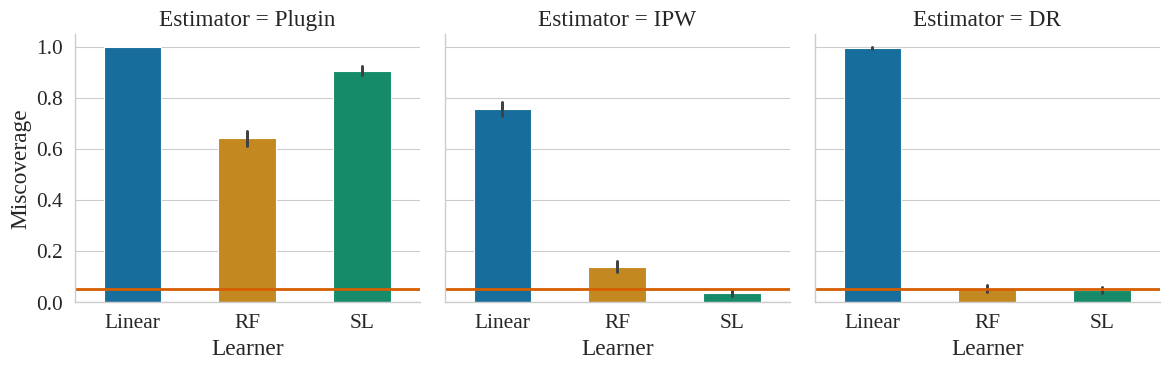

In [15]:
def bernoulli_ci(xs):
    m = xs.mean()
    se = np.sqrt(m * (1 - m) / len(xs))
    return max(0, m - 1.96 * se), min(1, m + 1.96 * se)

cc.set_theme(style="whitegrid", font=FONT)  # grid on
fg = sns.FacetGrid(miscov_df, col="Estimator", hue="Learner", height=4)
fg.map_dataframe(
    sns.barplot, x="Learner", y="Miscoverage", 
    order=learners, errorbar=bernoulli_ci, width=0.5,
)
for ax in fg.axes[0]:
    ax.axhline(ALPHA, linewidth=2, color=cc.get_color_by_index(3))
    ax.set_xticklabels(["Linear", "RF", "SL"])

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "miscoverage.pdf"))

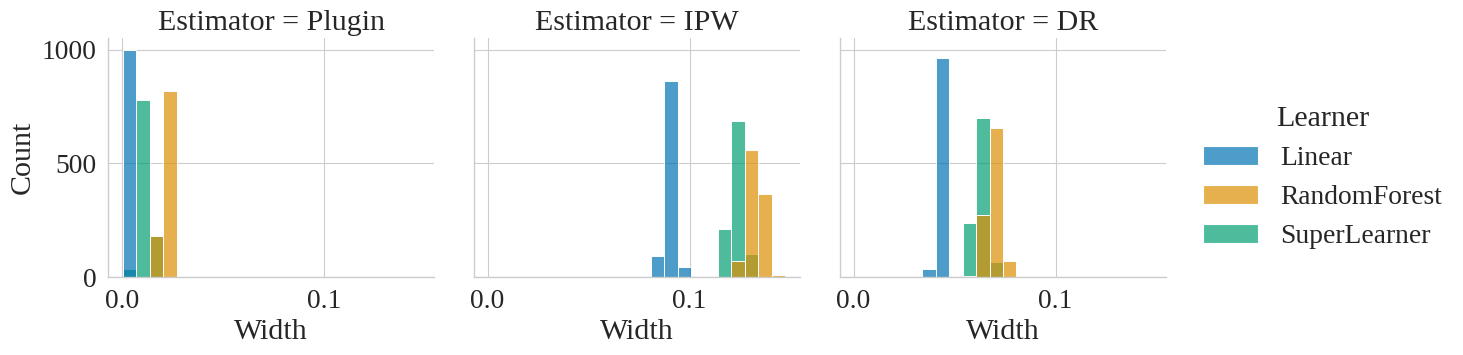

In [16]:
# RF can blow up
cc.set_theme(font_scale=2.25, font=FONT)
fg = sns.displot(
    x="Width",
    col="Estimator",
    hue="Learner",
    alpha=0.7,
    data=miscov_df,
    aspect=0.8,
    height=4,
)
sns.move_legend(fg, "center right", bbox_to_anchor=(1.22, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "width.pdf"))

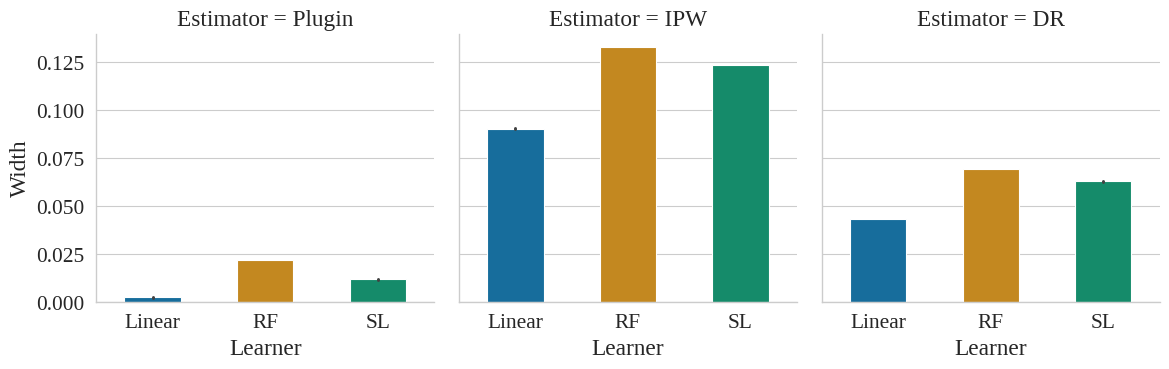

In [17]:
cc.set_theme(font_scale=1.75, font=FONT)
fg = sns.FacetGrid(miscov_df, col="Estimator", hue="Learner", height=4)
fg.map_dataframe(
    sns.barplot, x="Learner", y="Width", 
    order=learners, errorbar="ci", width=0.5,
)
for ax in fg.axes[0]:
    ax.set_xticklabels(["Linear", "RF", "SL"])
    #ax.set_yscale("log")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "width_bar.pdf"))

## Positivity

In [ ]:
epsilons = [0.1, 0.15, 0.2, 0.3, 0.5]

estimator = "dr"

# parallel RNG (independent seeds; some randomness from individual learner training steps)
rng = np.random.default_rng(RANDOM_SEED)
ss = rng.bit_generator._seed_seq
child_states = ss.spawn(N_TRIALS)

miscov_df_rows = []
miscov_summary = OrderedDict()
for learner in learners:
    for epsilon in epsilons:
        print(learner, epsilon)
        t0 = time.time()
        results = Parallel(n_jobs=N_JOBS)(
                delayed(compute_miscov)(seed) for seed in child_states
        )
        miscov_df_rows.extend([{"Learner": learner, "Epsilon": epsilon,
                                "Miscoverage": mc, "Width": min(2, w)}  # assumed: bounded score
                               for mc, w in results])
        miscovs, widths = zip(*results)
        m = np.mean(miscovs)
        se = np.sqrt(m * (1-m) / len(miscovs))
        print("miscoverage rate [learner: {}, epsilon: {}]: {} +/- {:.3f}".format(
            learner, epsilon, m, se
        ))
        miscov_summary[learner, epsilon] = m, se, np.mean(widths), np.std(widths)

        t1 = time.time()
        print("elapsed time (n_jobs={}): {:.2f}s".format(N_JOBS, t1 - t0))

In [19]:
miscov_df = pd.DataFrame(miscov_df_rows)
miscov_df.to_csv(os.path.join(PLOTS_DIR, "miscoverage_by_positivity.csv"))
miscov_df

,Learner,Epsilon,Miscoverage,Width
0,Linear,0.1,True,0.036047
1,Linear,0.1,True,0.037917
2,Linear,0.1,True,0.036097
3,Linear,0.1,True,0.037045
4,Linear,0.1,True,0.037840
...,...,...,...,...
14995,SuperLearner,0.5,False,0.059224
14996,SuperLearner,0.5,False,0.057603
14997,SuperLearner,0.5,False,0.059418
14998,SuperLearner,0.5,False,0.055658


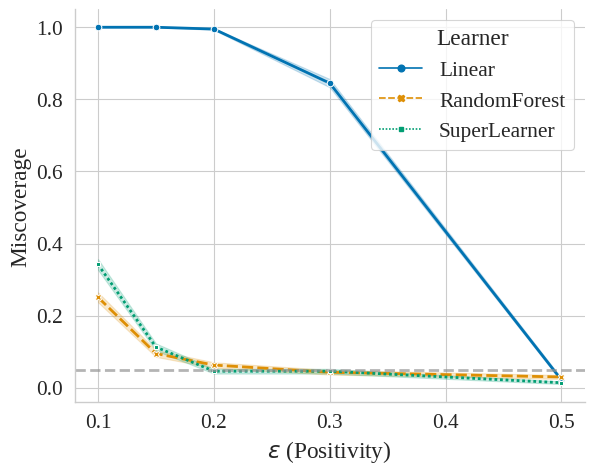

In [22]:
fg = sns.relplot(
    x="Epsilon",
    y="Miscoverage",
    hue="Learner",
    style="Learner",
    kind="line",
    linewidth=2,
    markers=True,
    errorbar="se",
    data=miscov_df,
    height=5,
    aspect=1.25,
    facet_kws={"legend_out": False},
)
fg.axes[0, 0].set_xlabel(r"$\epsilon$" + " (Positivity)")
fg.axes[0, 0].axhline(y=0.05, alpha=0.7, linewidth=2, linestyle="--",
                      color=cc.get_color_by_index(7))
# sns.move_legend(fg, "center", bbox_to_anchor=(0.45, 0.55))
fg.savefig(os.path.join(PLOTS_DIR, "miscoverage_by_positivity.pdf"))

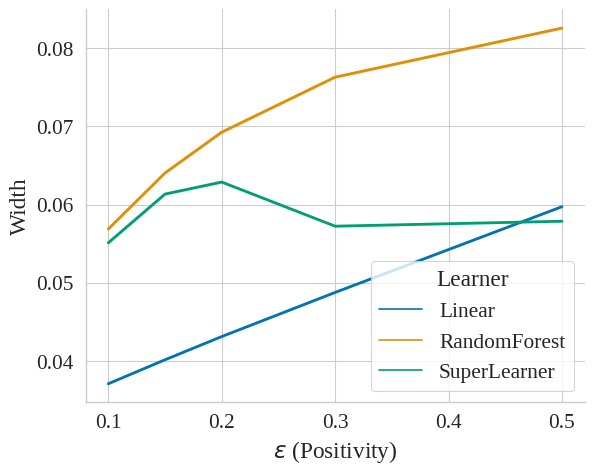

In [23]:
fg = sns.relplot(
    x="Epsilon",
    y="Width",
    hue="Learner",
    kind="line",
    linewidth=2,
    markers=True,
    errorbar="se",
    data=miscov_df,
    aspect=1.25,
    facet_kws={"legend_out": False},
)
fg.axes[0, 0].set_xlabel(r"$\epsilon$" + " (Positivity)")
fg.savefig(os.path.join(PLOTS_DIR, "width_by_positivity.pdf"))